In [1]:
#%% Initialization code
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gauss_pdf(x,mu,sigma):
    return np.exp( -(x-mu)**2/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

## 1. Response distributions
The Gaussian probability density function (pdf) is described by the following equation:

$$
f(x) = \dfrac{1}{\sqrt{2\pi\sigma^2}} e^{-\dfrac{(x-x_0)^2}{2\sigma^2}}
$$

We have used this function to generate two Gaussian distributions that correspond to the distribution of neuronal firing rates when a stimulus has been presented (S+) and when no stimulus has been presented (S-). Assuming both conditions have been presented equally, we can combine these distributions to generate an overall response distribution


In [20]:
# Distribution parameters
mu_1 = 5
sigma_1 = 0.5

mu_2 = 7
sigma_2 = 1

# Generate the distributions
x = np.arange(2.9,12,0.01)
r_smin = gauss_pdf(x,mu_1,sigma_1)
r_splus = gauss_pdf(x,mu_2,sigma_2)
r = 0.5*r_smin + 0.5*r_splus

And finally we plot the resulting distributions

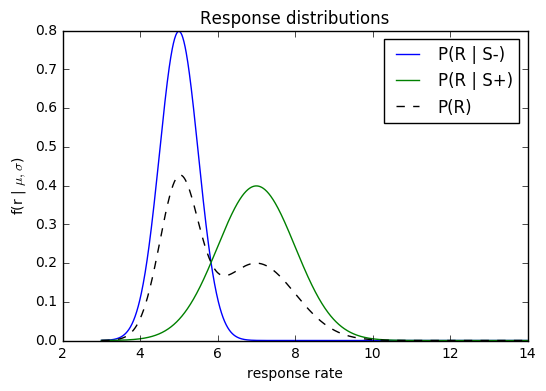

In [20]:
plt.plot(x,r_smin)
plt.plot(x,r_splus)
plt.plot(x,r,'--k')
plt.xlabel('response rate')
plt.ylabel('f(r | $\mu, \sigma$)')
plt.legend(['P(R | S-)','P(R | S+)','P(R)'])
plt.title('Response distributions')


## 2. Likelihood ratio

These conditional distributions can now be used to look for a threshold response rate. If we only have knowledge of the response rate of this neuron, this threshold can be used to decide if a stimulus was presented to the neuron. The best candidate for this threshold is the first value of the response rate that is more likely to have been produced by S+ conditional distribution than the S- distribution. This can be obtained by calculating the likelihood ratio and evaluating at what value of r it becomes greater than 1

$$
LR = \dfrac{P(r | S+)}{P(r | S-)} > 1
$$


Threshold response value:  5.83


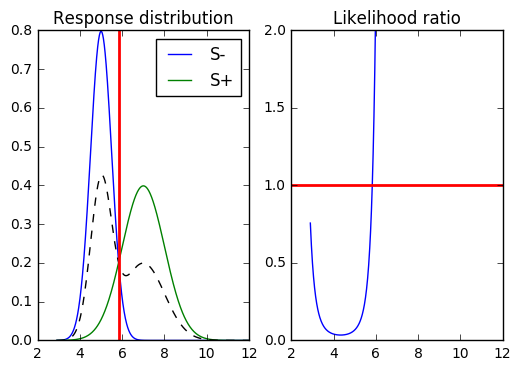

In [21]:
lr = r_splus/r_smin
lr_1 = np.argmax(lr >= 1)
print "Threshold response value: ", x[lr_1]
plt.subplot(121)
plt.plot(x,r_smin)
plt.plot(x,r_splus)
plt.plot(x,r,'--k')
plt.axvline(x[lr_1],linewidth=2,color='r')
plt.legend(['S-','S+'])
plt.title('Response distribution')
plt.subplot(122)
plt.plot(x,lr)
plt.axhline(y=1,linewidth = 2, color='r')
plt.ylim(0,2)
plt.title('Likelihood ratio')



## 3. Sampling the response distribution

An interesting extension of this idea is that response distribution function might be sampled repeatedly to get a better estimate of the stimulus. For each neural response we calculate the likelihood ratio and integrate this values until some threshold is reached.

In the following code we simulate this process by repeatedly sampling from the response distribution. In the first case the samples come from a uniform distribution centered on the threshold value. The second and third case use samples that are biased towards S- and S+ respectively.


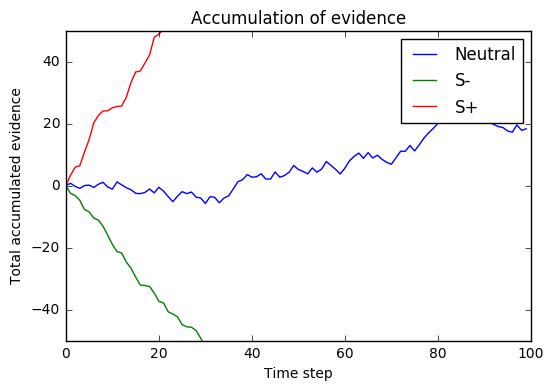

In [14]:
n_samples = 100
evidence = np.zeros((3,n_samples))

for i in range(1,n_samples):
    sample = np.random.randint(lr_1-50,lr_1+50) # CASE 1: threshold
    evidence[0,i] = evidence[0,i-1] + np.log(lr[sample])
    sample = np.random.randint(lr_1-100,lr_1)   # CASE 2: S- biased
    evidence[1,i] = evidence[1,i-1] + np.log(lr[sample])
    sample = np.random.randint(lr_1,lr_1+100)   # CASE 3: S+ biased
    evidence[2,i] = evidence[2,i-1] + np.log(lr[sample])
    
plt.plot(evidence.transpose())
plt.ylim(-50,50)
plt.title('Accumulation of evidence')
plt.xlabel('Time step')
plt.ylabel('Total accumulated evidence')
plt.legend(['Neutral','S-','S+'])

## 4. Taking priors into account

Until now we have assumed that both S+ and S- were presented with equal probabilities. When this is not the case, these prior stimulus probabilities should be taken into account as they will provide a more optimal threshold value. An intuitive way of understanding this is that if S+ is presented with a small probability, then it probably doesn't hurt to choose a higher response threshold as most responses will be caused by S- anyway. The likelihood ratio would then be computed as follows:

$$
LR = \dfrac{P(S+)P(R | S+)}{P(S-)P(R | S-)} > 1
$$


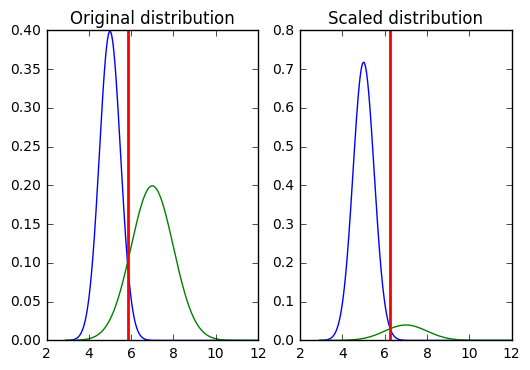

In [26]:
p_smin = 0.9
p_splus = 0.1

sr_smin = p_smin*r_smin
sr_splus = p_splus*r_splus
lr_1 = np.argmax((r_splus/r_smin) >= 1)
lr_2 = np.argmax((sr_splus/sr_smin) >= 1)

plt.subplot(121)
plt.plot(x,0.5*r_smin)
plt.plot(x,0.5*r_splus)
plt.axvline(x[lr_1],linewidth=2,color='r')
plt.title('Original distribution')
plt.subplot(122)
plt.plot(x,sr_smin)
plt.plot(x,sr_splus)
plt.axvline(x[lr_2],linewidth=2,color='r')
plt.title('Scaled distribution')

A final factor which can be taken into account are penalties for making an incorrect decision. Incorrectly deciding that stimulus was presented when in fact it was not (=false alarm) corresponds to a penalty L+ and likewise incorrectly deciding that the stimulus was not presented when it was(=miss) corresponds to a penalty L-. If these penalties are taken into account an optimal threshold value can be obtained by choosing the value for which the cost for a false alarm is smaller than the cost for a miss. Working out the algebra then leads to the following decision criterion


$$
LR = \dfrac{P(S+)P(R | S+)}{P(S-)P(R | S-)} > \dfrac{L+}{L-}
$$

In the case where stimulus probabilities and response penalties are equal we are back to the first equation.